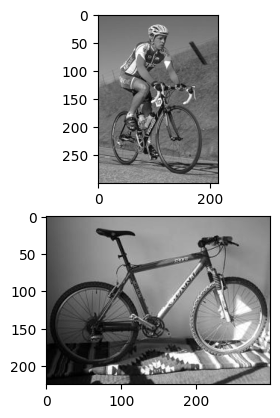

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

filepath = os.getcwd()

image1 = cv2.imread("./sample1.jpg", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("./sample2.jpg", cv2.IMREAD_GRAYSCALE)

plt.subplot(2,1,1)
plt.imshow(image1, cmap="gray")
plt.subplot(2,1,2)
plt.imshow(image2, cmap="gray")
plt.show()

In [2]:
image1 = np.float32(image1)
image2 = np.float32(image2)

In [3]:
print(image1)

[[104. 104. 104. ... 106. 106. 106.]
 [104. 104. 104. ... 106. 106. 106.]
 [104. 104. 104. ... 106. 106. 106.]
 ...
 [140. 139. 148. ... 140. 137. 139.]
 [145. 147. 157. ... 136. 130. 133.]
 [150. 157. 166. ... 129. 122. 121.]]


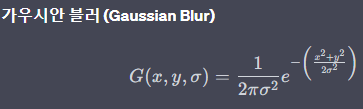

In [4]:
def GaussianKernel(size, sigma):
    arr = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(arr, arr)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma ** 2)) 
    kernel /= kernel.sum()
    return np.array(kernel)

In [5]:
kernel = GaussianKernel(5, 1)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


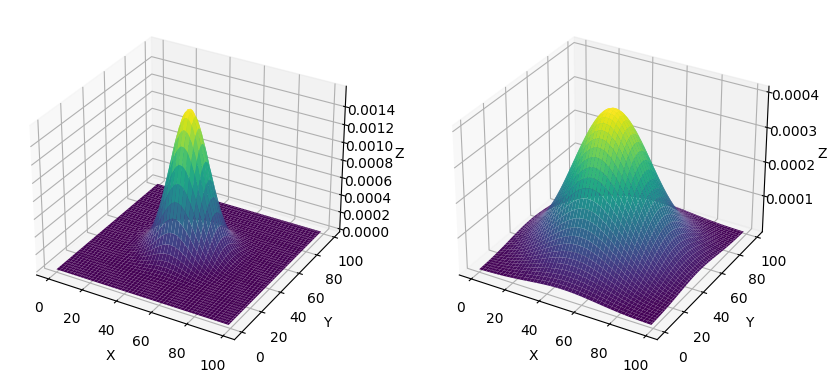

In [6]:
kernel_plot1 = GaussianKernel(100, 10)
kernel_plot2 = GaussianKernel(100, 20)

# x, y, z 좌표 생성
x = np.linspace(0, kernel_plot1.shape[1]-1, kernel_plot1.shape[1])
y = np.linspace(0, kernel_plot1.shape[0]-1, kernel_plot1.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x, y, kernel_plot1, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x, y, kernel_plot2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [7]:
def convolve2d(image, kernel):
    image_height, image_width = image.shape[0], image.shape[1]
    kernel_height, kernel_width = kernel.shape[0], kernel.shape[1]  # 수정된 부분

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    output = np.zeros_like(image)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    for x in range(image_height):
        for y in range(image_width):
            region = padded_image[x:x+kernel_height, y:y+kernel_width]
            output[x, y] = np.sum(region * kernel)
    
    return output


def gaussian_filter(image, kernel_size, sigma):
    kernel = GaussianKernel(kernel_size, sigma)
    filter = convolve2d(image, kernel)
    return filter

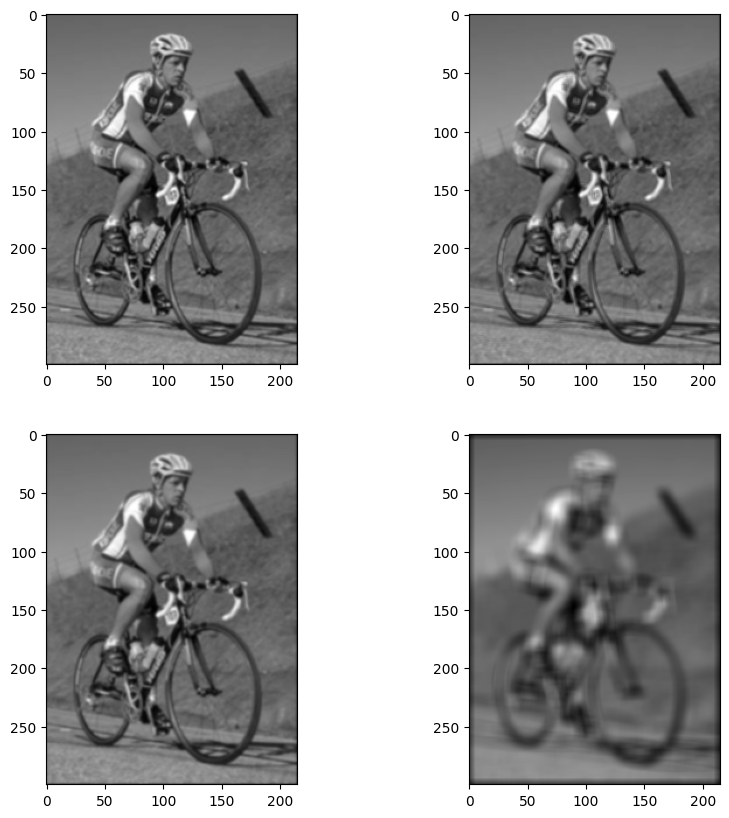

In [8]:
blurred_image1 = gaussian_filter(image1, kernel_size=3, sigma=1)
blurred_image2 = gaussian_filter(image1, kernel_size=3, sigma=10)
blurred_image3 = gaussian_filter(image1, kernel_size=11, sigma=1)
blurred_image4 = gaussian_filter(image1, kernel_size=11, sigma=10)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(blurred_image1, cmap="gray")

plt.subplot(2,2,2)
plt.imshow(blurred_image2, cmap="gray")

plt.subplot(2,2,3)
plt.imshow(blurred_image3, cmap="gray")

plt.subplot(2,2,4)
plt.imshow(blurred_image4, cmap="gray")

plt.show()

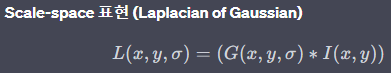  
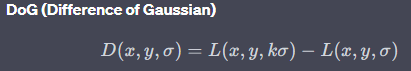

In [9]:
def build_gaussian_pyramid(image, num_octaves, num_scales, sigma):
    
    pyramids = []
    for octave in range(int(num_octaves)):
        scales = []
        for scale in range(int(num_scales)):
            size = 2 ** octave
            k = 2 ** (scale / num_scales)
            sigma_ = sigma * k
            blurred = gaussian_filter(image, kernel_size=3, sigma=sigma_)
            resized = cv2.resize(blurred, (image.shape[1] // size, image.shape[0] // size), interpolation=cv2.INTER_LINEAR)
            scales.append(resized)
        pyramids.append(scales)
    return pyramids


def compute_DoG(pyramids):
    DoGs = []
    for octave in pyramids:
        DoG = []
        for i in range(1, len(octave)):
            DoG.append(octave[i] - octave[i-1])
        DoGs.append(DoG)
    return DoGs

In [10]:
pyramid = build_gaussian_pyramid(image1, 4., 5., 1.)
print(len(pyramid))
print(len(pyramid[0]))
print(len(pyramid[0][0]))
print(len(pyramid[0][0][0]))

4
5
300
215


In [11]:
print(len(pyramid[1][0]))
print(len(pyramid[1][0][0]))
print(len(pyramid[2][0]))
print(len(pyramid[2][0][0]))
print(len(pyramid[3][0]))
print(len(pyramid[3][0][0]))

150
107
75
53
37
26


In [12]:
def visualize_pyramid(pyramids):
    num_octaves = len(pyramids)
    num_scales = len(pyramids[0])
    
    fig, axs = plt.subplots(num_octaves, num_scales, figsize=(num_scales * 5, num_octaves * 5))
    
    for i in range(num_octaves):
        for j in range(num_scales):
            axs[i, j].imshow(pyramids[i][j], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Octave {i+1}, Scale {j+1}')
    
    plt.tight_layout()
    plt.show()

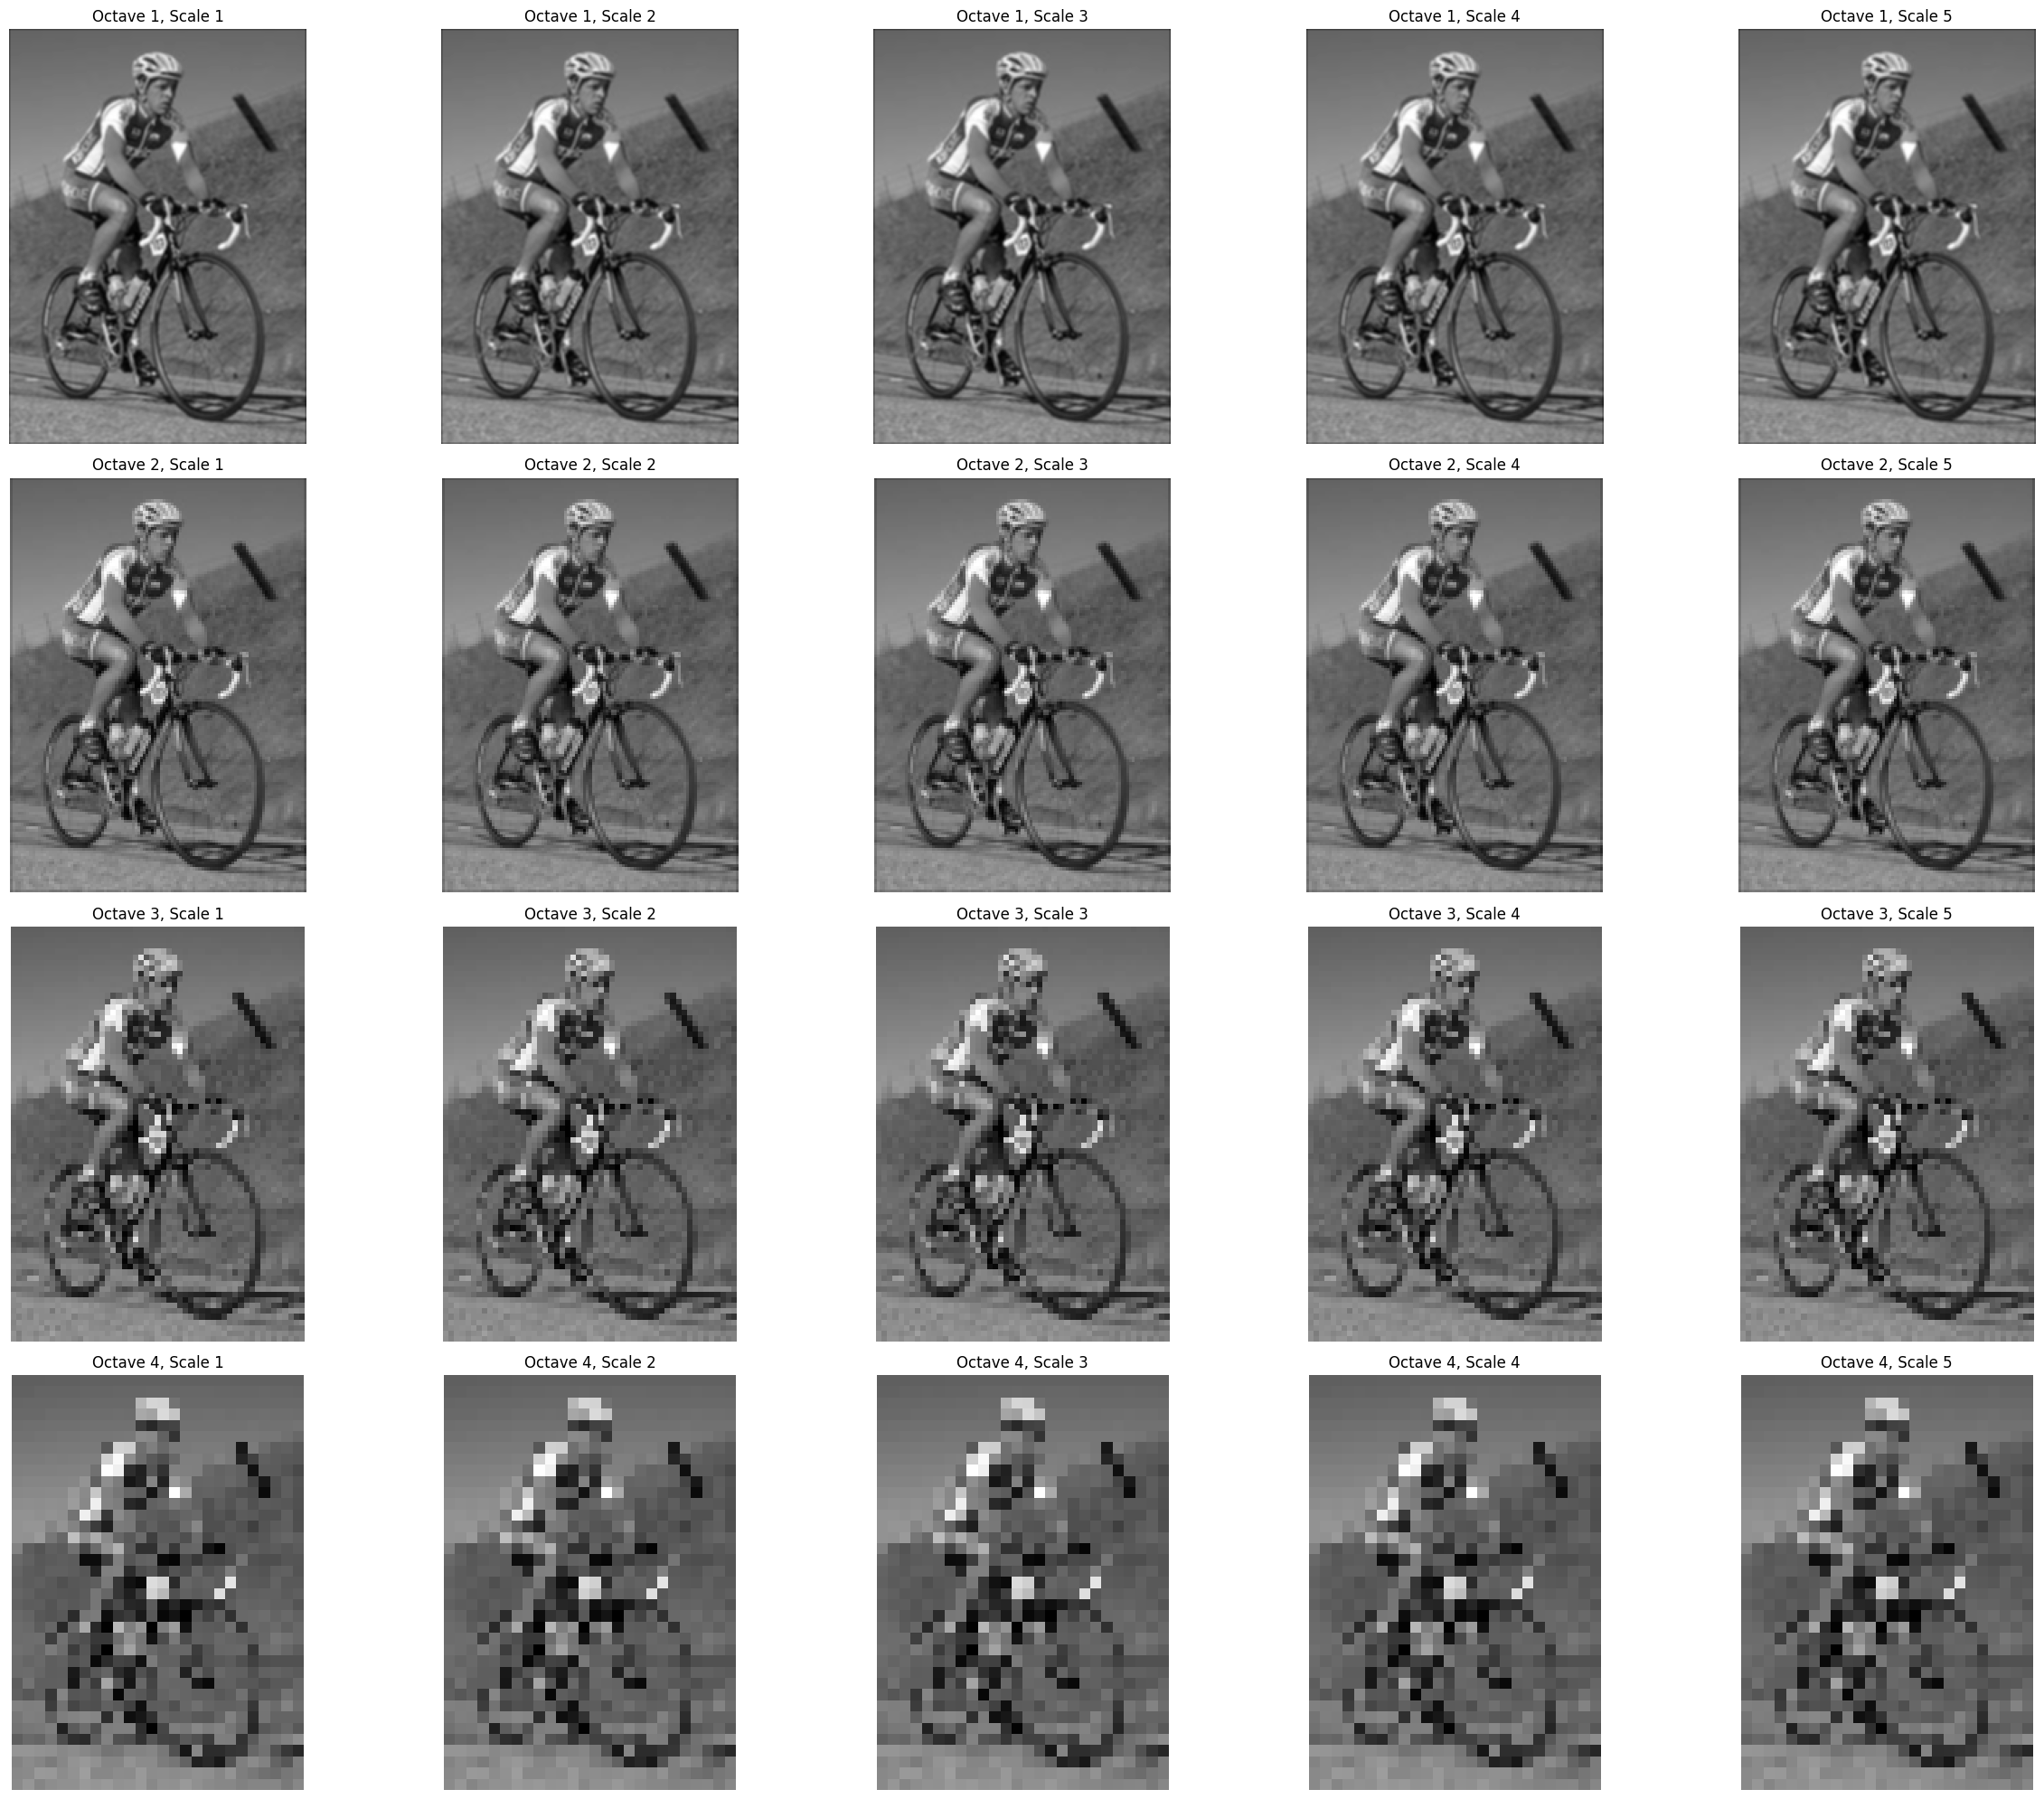

In [13]:
visualize_pyramid(pyramid)

In [14]:
DoG = compute_DoG(pyramid)

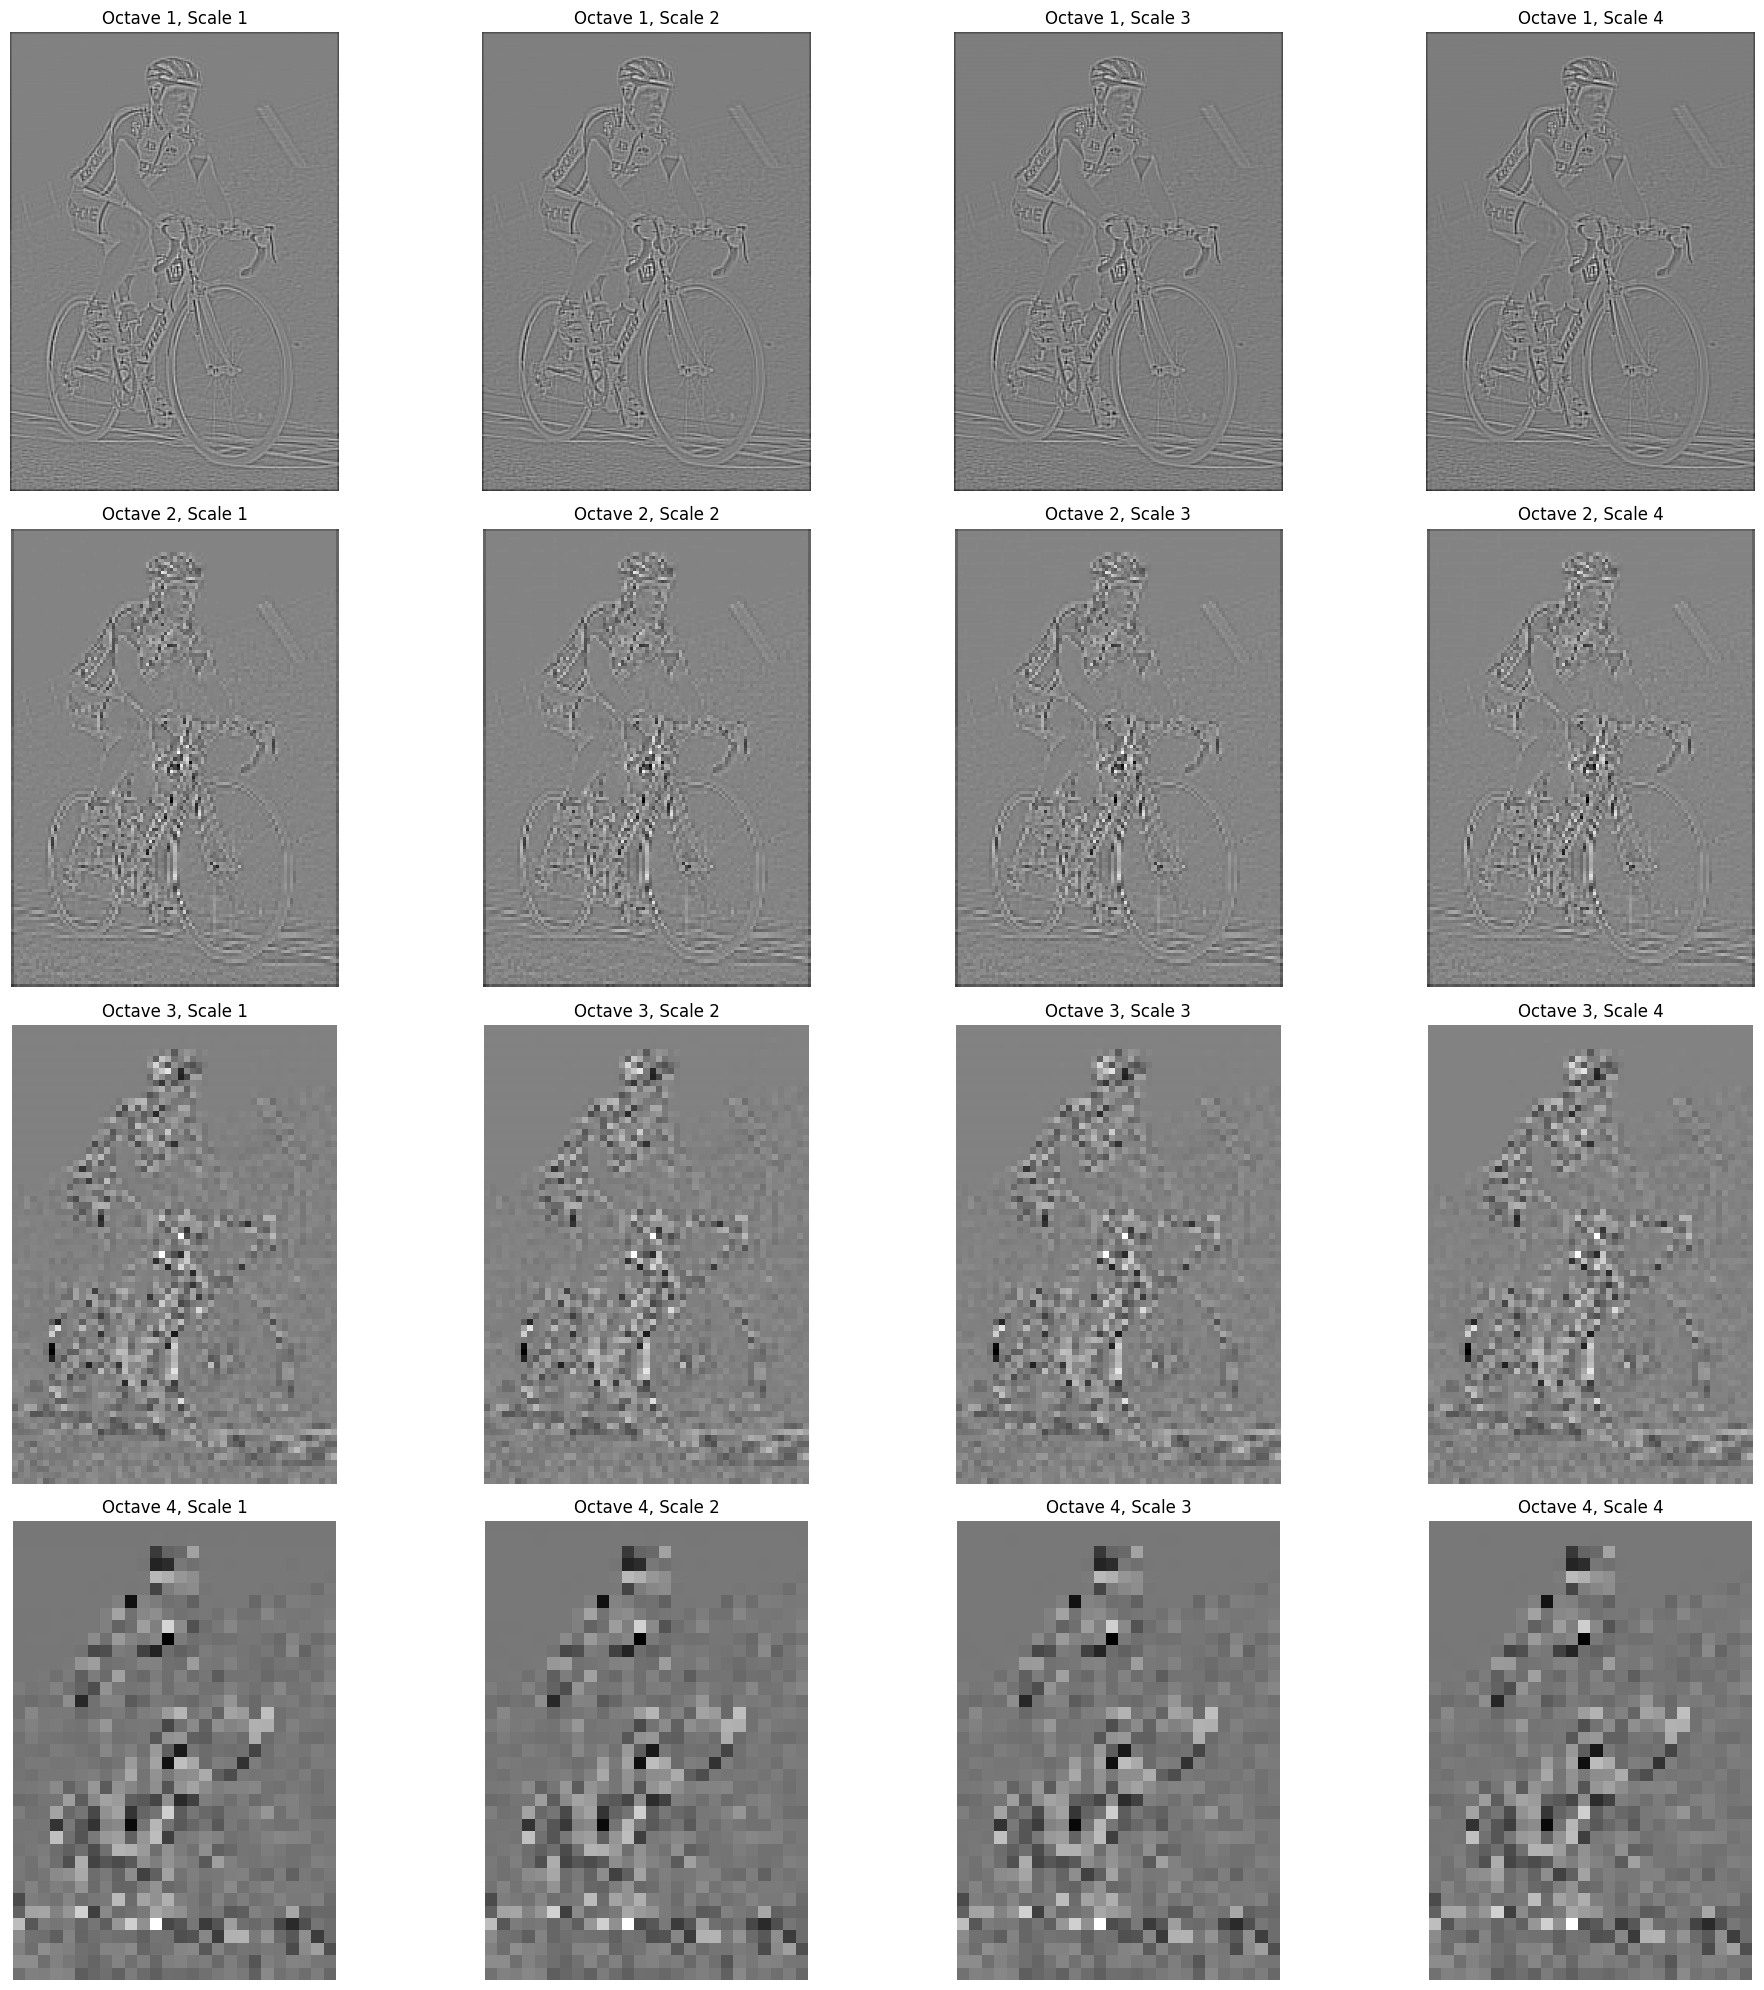

In [15]:
visualize_pyramid(DoG)

In [16]:
print(DoG)

[[array([[-2.2250366 , -1.5484161 , -1.5484161 , ..., -1.5781937 ,
        -1.5781937 , -2.267826  ],
       [-1.5484161 ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.5781937 ],
       [-1.5419083 ,  0.01488495,  0.01488495, ...,  0.01488495,
         0.01488495, -1.5716934 ],
       ...,
       [-2.0323563 ,  0.28938293,  0.01301575, ..., -0.19354248,
        -0.08934021, -2.1689835 ],
       [-2.1123047 ,  0.11535645, -0.18328857, ..., -0.08094788,
         0.06044006, -2.0219803 ],
       [-3.238083  , -2.4230957 , -2.6909637 , ..., -1.8378067 ,
        -1.6331177 , -2.5376968 ]], dtype=float32), array([[-1.6293716 , -1.1547775 , -1.1547775 , ..., -1.1769867 ,
        -1.1769867 , -1.6607056 ],
       [-1.1547775 ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.1769867 ],
       [-1.1502151 ,  0.0111084 ,  0.0111084 , ...,  0.0111084 ,
         0.0111084 , -1.1724167 ],
       ...,
       [-1.5180054 ,  0.2155304 ,  0.00912476, ..., -0.14

In [17]:
def find_keypoints(DoGs):
    keypoints = []
    for o, octave in enumerate(DoGs):
        for s, scale in enumerate(octave):
            height, width = scale.shape
            for i in range(1, height - 1):
                for j in range(1, width - 1):
                    patch = scale[i-1:i+2, j-1:j+2]
                    pixel = scale[i, j]
                    
                    if pixel == np.max(patch) or pixel == np.min(patch):
                        keypoints.append((i, j, o, s))
    return keypoints


In [18]:
keypoints = find_keypoints(DoG)
keypoints

[(1, 120, 0, 0),
 (1, 122, 0, 0),
 (1, 123, 0, 0),
 (1, 124, 0, 0),
 (1, 125, 0, 0),
 (1, 127, 0, 0),
 (1, 184, 0, 0),
 (1, 186, 0, 0),
 (1, 187, 0, 0),
 (1, 188, 0, 0),
 (1, 189, 0, 0),
 (1, 191, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (2, 13, 0, 0),
 (2, 14, 0, 0),
 (2, 15, 0, 0),
 (2, 16, 0, 0),
 (2, 17, 0, 0),
 (2, 18, 0, 0),
 (2, 19, 0, 0),
 (2, 20, 0, 0),
 (2, 21, 0, 0),
 (2, 23, 0, 0),
 (2, 25, 0, 0),
 (2, 26, 0, 0),
 (2, 27, 0, 0),
 (2, 28, 0, 0),
 (2, 29, 0, 0),
 (2, 30, 0, 0),
 (2, 31, 0, 0),
 (2, 32, 0, 0),
 (2, 33, 0, 0),
 (2, 34, 0, 0),
 (2, 35, 0, 0),
 (2, 36, 0, 0),
 (2, 37, 0, 0),
 (2, 38, 0, 0),
 (2, 39, 0, 0),
 (2, 40, 0, 0),
 (2, 41, 0, 0),
 (2, 42, 0, 0),
 (2, 43, 0, 0),
 (2, 44, 0, 0),
 (2, 45, 0, 0),
 (2, 47, 0, 0),
 (2, 49, 0, 0),
 (2, 50, 0, 0),
 (2, 51, 0, 0),
 (2, 52, 0, 0),
 (2, 53, 0, 0),
 (2, 54, 0, 0),
 (2, 

sobel filter  
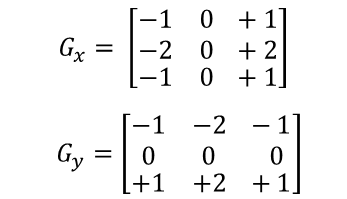

In [19]:
def show_sobel_filter(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    
    plt.subplot(1,2,1)
    plt.imshow(gradient_x, cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(gradient_y, cmap = "gray")
    plt.show()

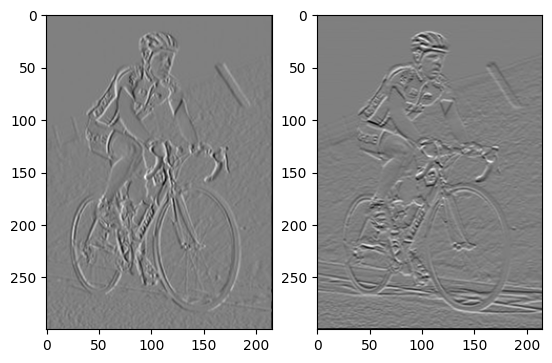

In [20]:
show_sobel_filter(image1)

In [21]:
def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    orientation[orientation < 0] += 360
    
    return magnitude, orientation

def assign_orientations(keypoints, pyramids):
    gradients = {}
    for o in range(len(pyramids)):
        gradients[o] = [compute_gradients(scale) for scale in pyramids[o]]
        
    for i, keypoint in enumerate(keypoints):
        y, x, o, s = keypoint
        magnitude, orientation = gradients[o][s]
        
        hist, bins = np.histogram(orientation[max(y-8,0):min(y+8,magnitude.shape[0]), 
                                              max(x-8,0):min(x+8,magnitude.shape[1])], 
                                   bins=36, range=(0, 360))
        max_bin = np.argmax(hist)
        
        keypoints[i] = {'position': (y, x), 'octave': o, 'scale': s, 'orientation': bins[max_bin], 'magnitude': hist[max_bin]}
    print(gradients)
    return keypoints
        
def compute_descriptors(keypoints, pyramids):
    gradients = {}
    for o in range(len(pyramids)):
        gradients[o] = [compute_gradients(scale) for scale in pyramids[o]]
    
    descriptors = []
    for keypoint in keypoints:
        y, x = keypoint['position']
        o, s = keypoint['octave'], keypoint['scale']
        magnitude, orientation = gradients[o][s]
        
        # Compute the descriptor
        descriptor = []
        for dx in range(max(y-8,0), min(y+8,magnitude.shape[0]), 4):
            for dy in range(max(x-8,0), min(x+8,magnitude.shape[1]), 4):
                hist, bins = np.histogram(orientation[dx:dx+4, dy:dy+4], bins=8, range=(0, 360))
                descriptor.extend(hist)
        
        # Normalize the descriptor
        descriptor = np.array(descriptor)
        descriptor = descriptor / np.sqrt(np.sum(descriptor**2))
        descriptors.append(descriptor)
    
    return descriptors


In [22]:
import time

def sift_algorithm(image, num_octaves=4, num_scales=5, sigma=1):
    start_time = time.time()
    
    # Step 1: Scale-space Extrema Detection
    pyramids_start_time = time.time()
    pyramids = build_gaussian_pyramid(image, num_octaves, num_scales, sigma)
    print(f"Scale-space Extrema Detection time: {time.time() - pyramids_start_time:.4f} seconds")
    
    # Step 2: Keypoint Localization
    keypoints_start_time = time.time()
    DoGs = compute_DoG(pyramids)
    keypoints = find_keypoints(DoGs)
    print(f"Keypoint Localization time: {time.time() - keypoints_start_time:.4f} seconds")
    
    # Step 3: Orientation Assignment
    orientations_start_time = time.time()
    keypoints_with_orientations = assign_orientations(keypoints, pyramids)
    print(f"Orientation Assignment time: {time.time() - orientations_start_time:.4f} seconds")
    
    # Step 4: Keypoint Descriptor
    descriptors_start_time = time.time()
    descriptors = compute_descriptors(keypoints_with_orientations, pyramids)
    print(f"Keypoint Descriptor time: {time.time() - descriptors_start_time:.4f} seconds")
    
    print(f"Total time: {time.time() - start_time:.4f} seconds")
    
    return keypoints_with_orientations, descriptors



In [23]:
def visualize_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    for keypoint in keypoints:
        y, x = keypoint['position']
        plt.plot(x, y, 'r.', markersize=5)
        orientation = keypoint.get('orientation', 0)
        magnitude = keypoint.get('magnitude', 5)
        dx = magnitude * np.cos(np.deg2rad(orientation))
        dy = magnitude * np.sin(np.deg2rad(orientation))
        plt.arrow(x, y, dx, dy, color='y', width=0.1)
    plt.show()

def visualize_descriptors(descriptors):
    for descriptor in descriptors:
        plt.figure()
        plt.bar(range(len(descriptor)), descriptor)
        plt.show()

In [36]:
keypoints, descriptors = sift_algorithm(image1)

Scale-space Extrema Detection time: 3.0805 seconds
Keypoint Localization time: 1.0054 seconds
{0: [(array([[360.6156  , 393.74844 , 416.      , ..., 424.      , 401.32053 ,
        367.5505  ],
       [394.1379  , 150.96718 , 115.108826, ..., 117.30139 , 153.85544 ,
        401.71    ],
       [417.2779  , 114.39371 ,   2.903717, ...,   2.903717, 116.58566 ,
        425.2778  ],
       ...,
       [579.9006  , 186.72968 ,  25.114433, ...,  15.783209, 155.18773 ,
        539.66876 ],
       [561.1889  , 214.2097  , 135.98004 , ..., 165.36711 , 216.70308 ,
        502.42688 ],
       [519.7641  , 570.7816  , 605.5872  , ..., 536.5709  , 502.24774 ,
        450.79788 ]], dtype=float32), array([[4.5000000e+01, 7.9776497e+01, 9.0000000e+01, ..., 9.0000000e+01,
        1.0022350e+02, 1.3500000e+02],
       [1.0312563e+01, 4.5253887e+01, 9.0000000e+01, ..., 9.0000000e+01,
        1.3475087e+02, 1.6968910e+02],
       [2.4439390e-01, 1.3548478e+00, 9.0000000e+01, ..., 9.0000000e+01,
        1.

KeyboardInterrupt: 

In [ ]:
visualize_keypoints(image1, keypoints)
visualize_descriptors(descriptors)

In [25]:
print('keypoint:',len(keypoints))

keypoint: 84629


In [2]:
import cv2
img = cv2.imread('./sample1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# SIFT 추출기 생성
sift = cv2.SIFT_create()
# 키 포인트 검출과 서술자 계산
keypoints, descriptor = sift.detectAndCompute(gray, None)
print('keypoint:',len(keypoints), 'descriptor:', descriptor.shape)
print(descriptor)

# 키 포인트 그리기
img_draw = cv2.drawKeypoints(img, keypoints, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# 결과 출력
cv2.imshow('SIFT', img_draw)
cv2.waitKey()
cv2.destroyAllWindows()

keypoint: 467 descriptor: (467, 128)
[[ 0.  1. 12. ...  3.  0.  1.]
 [ 6.  5. 12. ... 13.  3.  2.]
 [49. 17.  2. ... 31. 10.  9.]
 ...
 [57. 64.  8. ... 26.  1.  1.]
 [47. 71. 34. ... 30. 25. 17.]
 [ 4.  0.  0. ...  1.  1.  6.]]


In [2]:
pip install opencv-contrib-python

In [12]:
pip uninstall opencv-python

^C
Note: you may need to restart the kernel to use updated packages.
